In [1]:
from spch_module.mode import Mode
from spch_module.facilities import get_comp_by_name, get_summ_collections
mode = Mode(283, [20, 20.55], 8)
comp = get_comp_by_name([
        'ГПА-ц3-16С-45-1.7(ККМ)',
        'ГПА Ц3 16с76-1.7М'
    ],[1,1])
stage = comp[0]

In [2]:
from spch_module.formulas import my_z
from scipy.optimize import root, root_scalar
import numpy as np
from spch_module.stage import Stage
def get_perc_by_mght(self:Stage, mode:Mode, mght:float):
    q_in = mode.q_in[self.idx] / self.w_cnt_current
    mas_rate =  q_in * self.lim.plot_std * (10**6) / 24 / 60 / 60
    def fun_p_in(kpd, z_in):
    # mght = cur_dh * mas_rate / kpd / (10**3)
        cur_dh = mght / mas_rate * kpd * (10**3)
        m_t =  (self.lim.k_val - 1) / (self.lim.k_val * kpd)
        comp_degree = (cur_dh * m_t / (z_in * self.lim.r_val * mode.t_in) + 1) ** (1 / m_t)
        return mode.p_input / comp_degree
    def func(x):
        freq, kpd, p_in = x
        z_in = my_z(p_in, mode.t_in)
        cur_p_in = fun_p_in(kpd, z_in)
        koef_raskh = self.type_spch.koef_raskh(q_in, cur_p_in, freq, mode.t_in, self.lim.r_val, self.lim.plot_std)
        cur_kpd = self.type_spch.calc_k_kpd(koef_raskh)
        koef_nap = self.type_spch.calc_k_nap(koef_raskh)
        u2_vel = (self.type_spch.vel(freq)/60)**2
        return [
            koef_nap * u2_vel - mght / mas_rate * kpd * (10**3),
            cur_kpd - kpd,
            cur_p_in - p_in
        ]
    x0_val = [self.type_spch.fnom, .8, self.type_spch.p_in]
    sol = root(fun=func, x0=x0_val)
    freq, kpd, p_in = sol.x
    curr_mode = mode.clone()
    curr_mode.p_input = fun_p_in(kpd, my_z(p_in, mode.t_in))
    summ = self.calc_stage_summary_in(curr_mode, freq)
    return summ
summs = [
    get_perc_by_mght(stage, mode, mght * 1000)
for mght in np.linspace(2,20,10)]
print(get_summ_collections([mode] * len(summs), summs))
# stage.show_plt(mode.t_in, 1.1, .5, summs)
print(f'proc {summs[2].percent_x}')
print(f'freq {summs[2].freq}')


Комер. расх. |Т.вх |Давл. (треб) |Давл. вых(треб) |Давл. вх | Тип СПЧ  |Частота |Мощность |Ст. сжатия |ГПА |Т.вых |Помп. удал |Об. расход |Пол. кпд 
 млн. м3/сут |  К  |     МПа     |       МПа      |   МПа   |          | об/мин |   кВт   |   д. ед.  | шт |   С  |   д. ед   |   м3/мин  |  д. ед  
 20.00+20.55 | 283 |    8.00     |      8.00      |  7.36   |16/45-1.7 |  1831  |  2000   |   1.09    | 1  |  3   |    23     |    156    |  0.80   
 20.00+20.55 | 283 |    8.00     |      8.00      |  6.83   |16/45-1.7 |  2540  |  4000   |   1.17    | 1  |  17  |     6     |    170    |  0.78   
 20.00+20.55 | 283 |    8.00     |      8.00      |  6.35   |16/45-1.7 |  3106  |  6000   |   1.26    | 1  |  24  |    -0     |    185    |  0.78   
 20.00+20.55 | 283 |    8.00     |      8.00      |  5.92   |16/45-1.7 |  3590  |  8000   |   1.35    | 1  |  31  |    -4     |    201    |  0.78   
 20.00+20.55 | 283 |    8.00     |      8.00      |  5.53   |16/45-1.7 |  4016  |  10000  |   1.45    | 1

In [3]:
from spch_module.formulas import dh
from spch_module.stage import Stage
from spch_module.mode import Mode
import matplotlib.pyplot as plt
def get_mght(self:Stage, mode:Mode, percent_x:float):
    koef_raskh = self.type_spch.koef_raskh_by_percent_x(percent_x)
    kpd = self.type_spch.calc_k_kpd(koef_raskh)
    koef_nap = self.type_spch.calc_k_nap(koef_raskh)
    q_in = mode.q_in[self.idx] / self.w_cnt_current
    mas_rate =  q_in * self.lim.plot_std * (10**6) / 24 / 60 / 60
    def mght_by_freq(freq):
        p_in = self.get_p_in_by_freq_and_perc_on_mode(mode, freq, percent_x)
        comp_degree = mode.p_input / p_in
        z_in = my_z(p_in, mode.t_in)
        cur_dh = dh(comp_degree, z_in, mode.t_in, self.lim.r_val, self.lim.k_val, kpd)
        mght = cur_dh * mas_rate / kpd / (10**3)
        return mght
    def func(freq):
        u_val = self.type_spch.vel(freq) / 60
        cur_dh = koef_nap * (u_val**2)
        return cur_dh * mas_rate / kpd / (10**3) - mght_by_freq(freq)

    x0_val = self.type_spch.fnom*.5
    sol = root_scalar(f=func, x0=x0_val, x1=x0_val*2, method='secant')
    freq = sol.root
    curr_mode = mode.clone()
    curr_mode.p_input = self.get_p_in_by_freq_and_perc_on_mode(mode, freq, percent_x)
    summ = self.calc_stage_summary_in(curr_mode, freq)
    return get_summ_collections([curr_mode], [summ])
        
get_mght(stage, mode, 0)



Комер. расх. |Т.вх |Давл. (треб) |Давл. вых(треб) |Давл. вх | Тип СПЧ  |Частота |Мощность |Ст. сжатия |ГПА |Т.вых |Помп. удал |Об. расход |Пол. кпд 
 млн. м3/сут |  К  |     МПа     |       МПа      |   МПа   |          | об/мин |   кВт   |   д. ед.  | шт |   С  |   д. ед   |   м3/мин  |  д. ед  
 20.00+20.55 | 283 |    6.40     |      8.00      |  6.40   |16/45-1.7 |  3060  |  5822   |   1.25    | 1  |  24  |    -0     |    184    |  0.78   


Комер. расх. |Т.вх |Давл. (треб) |Давл. вых(треб) |Давл. вх | Тип СПЧ  |Частота |Мощность |Ст. сжатия |ГПА |Т.вых |Помп. удал |Об. расход |Пол. кпд 
 млн. м3/сут |  К  |     МПа     |       МПа      |   МПа   |          | об/мин |   кВт   |   д. ед.  | шт |   С  |   д. ед   |   м3/мин  |  д. ед  
 20.00+20.55 | 283 |    4.71     |      8.00      |  4.71   |16/45-1.7 |  4925  |  15020  |   1.70    | 1  |  52  |    -7     |    260    |  0.78   


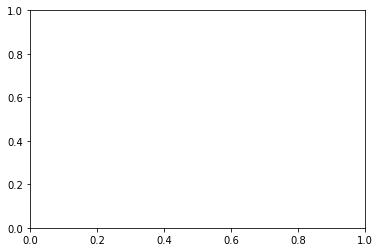

In [4]:
from spch_module.summary import StageSummary
from spch_module.stage import Stage
from spch_module.mode import Mode
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
fix, ax = plt.subplots()
stage = comp[0]
def get_perc_by_comp(self:Stage, mode:Mode, comp_degree:float)->StageSummary:
    p_in = mode.p_input / comp_degree
    q_in = mode.q_in[self.idx] / self.w_cnt_current
    z_in = my_z(p_in, mode.t_in)
    def func(freq):
        koef_raskh = self.type_spch.koef_raskh(q_in, p_in, freq, mode.t_in, self.lim.r_val, self.lim.plot_std)
        koef_nap = self.type_spch.calc_k_nap(koef_raskh)
        kpd = self.type_spch.calc_k_kpd(koef_raskh)
        u2_val = (self.type_spch.vel(freq)/ 60) ** 2 
        cur_dh = koef_nap * u2_val
        m_t =  (self.lim.k_val - 1) / (self.lim.k_val * kpd)
        cur_comp_degree = (cur_dh * m_t / (z_in * self.lim.r_val * mode.t_in) + 1) ** (1 / m_t)
        return comp_degree - cur_comp_degree
    # x_arr, y_arr = zip(*[
    #     (freq, func(freq))
    # for freq in np.linspace(1000, 10000 ,10)])
    # ax.plot(x_arr, y_arr)

    x0_val = self.type_spch.fnom
    sol = root_scalar(f=func, x0=x0_val, x1=x0_val*1.01)
    # print(sol)
    curr_mode = mode.clone()
    curr_mode.p_input = p_in
    summ = self.calc_stage_summary_in(curr_mode, sol.root)
    return get_summ_collections([curr_mode], [summ])
print(get_perc_by_comp(stage, mode, 1.7))

In [5]:
def get_comp_by_perc(self:Stage, mode:Mode, percent_x:float)->StageSummary:
    koef_raskh = self.type_spch.koef_raskh_by_percent_x(percent_x)
    kpd = self.type_spch.calc_k_kpd(koef_raskh)
    koef_nap = self.type_spch.calc_k_nap(koef_raskh)
    q_in = mode.q_in[self.idx] / self.w_cnt_current
    mas_rate =  q_in * self.lim.plot_std * (10**6) / 24 / 60 / 60
    def comp_by_freq(freq):
        p_in = self.get_p_in_by_freq_and_perc_on_mode(mode, freq, percent_x)
        comp_degree = mode.p_input / p_in
        return comp_degree, p_in
    def func(freq):
        u_val = self.type_spch.vel(freq) / 60
        cur_dh = koef_nap * (u_val**2)
        comp_by_freq_val, p_in =  comp_by_freq(freq)
        z_in = my_z(p_in, mode.t_in)
        m_t =  (self.lim.k_val - 1) / (self.lim.k_val * kpd)
        cur_comp_degree = (cur_dh * m_t / (z_in * self.lim.r_val * mode.t_in) + 1) ** (1 / m_t)
        return cur_comp_degree - comp_by_freq_val

    x0_val = self.type_spch.fnom*.5
    sol = root_scalar(f=func, x0=x0_val, x1=x0_val*2, method='secant')
    freq = sol.root
    curr_mode = mode.clone()
    curr_mode.p_input = self.get_p_in_by_freq_and_perc_on_mode(mode, freq, percent_x)
    summ = self.calc_stage_summary_in(curr_mode, freq)
    return get_summ_collections([curr_mode], [summ])

print(get_comp_by_perc(stage, mode, 0.1))


Комер. расх. |Т.вх |Давл. (треб) |Давл. вых(треб) |Давл. вх | Тип СПЧ  |Частота |Мощность |Ст. сжатия |ГПА |Т.вых |Помп. удал |Об. расход |Пол. кпд 
 млн. м3/сут |  К  |     МПа     |       МПа      |   МПа   |          | об/мин |   кВт   |   д. ед.  | шт |   С  |   д. ед   |   м3/мин  |  д. ед  
 20.00+20.55 | 283 |    6.40     |      8.00      |  6.40   |16/45-1.7 |  3050  |  5782   |   1.25    | 1  |  24  |     0     |    184    |  0.78   


None

Комер. расх. |Т.вх |Давл. (треб) |Давл. вых(треб) |Давл. вх | Тип СПЧ  |Частота |Мощность |Ст. сжатия |ГПА |Т.вых |Помп. удал |Об. расход |Пол. кпд 
 млн. м3/сут |  К  |     МПа     |       МПа      |   МПа   |          | об/мин |   кВт   |   д. ед.  | шт |   С  |   д. ед   |   м3/мин  |  д. ед  
 20.00+20.55 | 283 |    8.00     |      8.00      |  6.00   |16/76-1.7 |  3640  |  7641   |   1.33    | 1  |  17  |    45     |    214    |  0.84   
 20.00+20.55 | 283 |    8.00     |      8.00      |  4.13   |16/76-1.7 |  5720  |  19314  |   1.94    | 1  |  55  |    42     |    323    |  0.84   


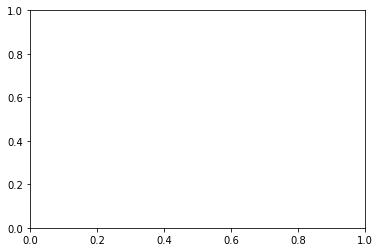

In [16]:
import matplotlib.pyplot as plt
_, ax = plt.subplots()
stage = comp[-1]
def get_freq_dim_by_perc(self:Stage, mode:Mode, percent_x:float):
    koef_raskh = self.type_spch.koef_raskh_by_percent_x(percent_x)
    self.type_spch.get_volume_rate_by_freq_and_perc
    kpd = self.type_spch.calc_k_kpd(koef_raskh)
    koef_nap = self.type_spch.calc_k_nap(koef_raskh)
    q_in = mode.q_in[self.idx] / self.w_cnt_current
    mas_rate =  q_in * self.lim.plot_std * (10**6) / 24 / 60 / 60
    def func(freq):
        cur_mode = mode.clone()
        cur_mode.p_input = self.get_p_in_by_freq_and_perc_on_mode(mode, freq, percent_x)
        summ = self.calc_stage_summary_in(cur_mode, freq)
        return summ.p_out_req - mode.p_input
    x0_val = self.type_spch.fnom
    bracket = [.3*x0_val,1.3*x0_val]
    try:
        sol = root_scalar(f=func, x0=x0_val, x1=x0_val * 1.001, bracket=bracket, method='brentq')
        cur_mode = mode.clone()
        cur_mode.p_input = self.get_p_in_by_freq_and_perc_on_mode(mode, sol.root, percent_x)
        summ = self.calc_stage_summary_in(cur_mode, sol.root)
        return summ
    except ValueError:
        return None

summ = get_freq_dim_by_perc(stage, mode, 0) 
print(summ)
summs = (
    stage.calc_stage_summary_out(mode, stage.type_spch.fnom * .7),
    stage.calc_stage_summary_out(mode, stage.type_spch.fnom * 1.1),
)

print(get_summ_collections([mode]*2, summs))